# Validação comparativa e por simulação dinâmica da *Lateral Directional Mode* *Dutch Roll Period Approximation*
Para ser possível a linearização é necessário fazer uma trimagem garantindo poucas variações para determinada fase de voo.

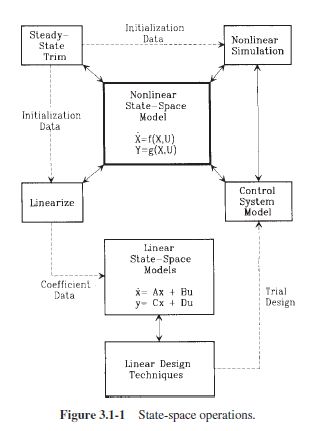

## *Steady-State Flight*
Quando se trima uma aeronave tem-se um *Steady-State Flight*, que é definido pelas caracteristicas abaixo:
- $\dot{P}$, $\dot{Q}$, $\dot{R}$ e $\dot{U}$, $\dot{V}$, $\dot{W}$ ou ($\dot{V_{T}}$, $\dot{\beta}$ e $\dot{\alpha}$) $\equiv 0$, controles fixos.

### *Steady Wings-Level-FLight*
Sendo mais específico para o caso do Steady Wings-Level-Flight tem-se:
- $\phi$, $\dot{\phi}$, $\dot{\theta}$, $\dot{\psi}$ $\equiv 0$, _i.e._ ($P$, $Q$, $R$ $\equiv 0$)

### Condições do *Steady-State* para a linearização:
- $\beta$, $\phi$, $P$, $Q$, $R$ $\equiv 0$
- Todas as derivadas $\equiv 0$
- $V_{T}=V_{T_{e}}$, $\alpha=\alpha_{e}$, $\theta=\theta_{e}$, $\psi\equiv 0$, $\gamma_{e}\equiv 0$,


In [36]:
from pathlib             import Path
import matplotlib.pyplot as plt
from scipy import signal
from scipy import linalg
from aerospace_ctrl_toolkit import (
    jsbsim_utils as jsbu,
    presets,
    trim,
    linearize as lin,
)

# Select aircraft
fdm = jsbu.load_aircraft(
    aircraft_model='f104',
    aircraft_path=(Path('.')/'..').resolve(),
)

presets.set_location0_formosa(fdm)

op_cruise = trim.trim_wings_level_flight(
    fdm = fdm,
    ic_h_sl_ft = 5000,
    ic_mach = 0.5,
    fuel_content_lbs = 1000,
    debug_level=2,
)

op_selected = op_cruise



 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 4.712979629061918e-19
       x: [ 8.092e-02 -1.900e-03 -6.474e-01 -1.729e-01 -3.068e-02
            8.717e-01]
     nit: 4
     jac: [-2.445e-03  3.804e-03  3.043e-05  1.097e-03  3.287e-05
            4.229e-03]
    nfev: 29
    njev: 4

Constraint eq 6.053335610545219e-11
Constraint eq -3.760037420308393e-12
Constraint eq 6.859792733848735e-10
Constraint eq -9.748068945092726e-13
Constraint eq 3.495280950062905e-12
Constraint eq 5.10805338799325e-13

Theta (deg):  4.636233950870773
Alpha (deg):  4.63623395087077
Alphadot (deg):  7.083783020155651e-11
Beta (deg):  -0.10885750951889692
Aileron (deg):  -11.652383733963362
Elevator (deg):  -3.112715514684907
Rudder (deg):  -0.5521957274235445
Throtle:  0.871717261467382
U_dot (m/s^2):  1.839777716838853e-11
W_dot (m/s^2):  2.0888506924165997e-10
VT_dot_mag (m/s^2):  2.0969370604963506e-10
VT_dot_angle (deg):  84.96660112645654


## *Lateral Directional Mode*
Garantido o *Steady-State Flight* pela trimagem é possivel o desacoplamento linear das equações de estado para o caso do modo Latero-Direcional tem-se os seguintes vetores de estado $x$ e controle $u$.
- x = [$\beta$ $\phi$ $p$ $r$] $^T$
- u = [$\delta_{a}$ $\delta_{r}$]$^T$

Sendo:
- $\beta$: Ângulo de glissada;
- $\phi$: *Roll*;
- $p$: Velocidade Angular de *Pitch*;
- $r$: Velocidade Angular de *Yaw*;
- $\delta_{a}$: Variação no *aileron*;
- $\delta_{r}$: Variação no *rudder*; 

A equação de estados:
- $E\dot{x}=Ax+Bu$

Onde,

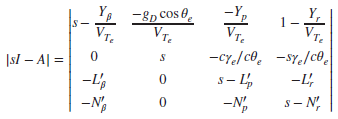

e,

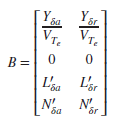





In [37]:
states = ['ic/beta-rad', 'ic/phi-rad', 'ic/p-rad_sec','ic/r-rad_sec']
states_deriv = ['aero/betadot-rad_sec','velocities/phidot-rad_sec', 'accelerations/pdot-rad_sec2', 'accelerations/rdot-rad_sec2']
inputs = ['fcs/aileron-cmd-norm', 'fcs/rudder-cmd-norm']
(A, B) = lin.linearize_core(
    fdm          = fdm,
    states       = states,
    states_deriv = states_deriv,
    inputs       = inputs,
    ic           = op_selected,
)

C = [0, 0, 0, 1]
D = [0, 0]
sys = signal.StateSpace(A, B, C, D)

print("Lateral Directional Trans Function Poles:")
print(sys.poles)
print("Lateral Directional Trans Function natural frequency:")
print(linalg.norm(sys.poles[0]))

w, mag, phase = signal.bode(sys, n=1000)

Lateral Directional Trans Function Poles:
[-0.93203392+3.28202498j -0.93203392-3.28202498j -0.95783227+0.j
 -0.04409989+0.j        ]
Lateral Directional Trans Function natural frequency:
3.4117994055650223


### *Dutch Roll Approximation*

A *Dutch Roll Approximatio* é uma simplificação do modo latero-direcional.

- x = [$\beta$ r]$^T$
- u = [$\delta_{a}$ $\delta_{r}$]$^T$

Sendo:
- $\beta$: Ângulo de glissada;
- $r$: Velocidade Angular de *Yaw*;
- $\delta_{a}$: Variação no *aileron*;
- $\delta_{r}$: Variação no *rudder*; 

A equação de estados:
- $E\dot{x}=Ax+Bu$

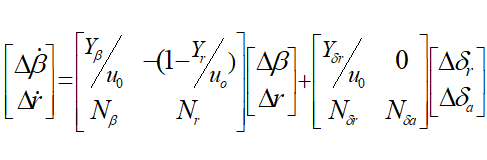







In [38]:
states = ['ic/beta-rad', 'ic/r-rad_sec']
states_deriv = ['aero/betadot-rad_sec', 'accelerations/rdot-rad_sec2']
inputs = ['fcs/aileron-cmd-norm', 'fcs/rudder-cmd-norm']
(A, B) = lin.linearize_core(
    fdm          = fdm,
    states       = states,
    states_deriv = states_deriv,
    inputs       = inputs,
    ic           = op_selected,
)
print(B)
C = [0, 1]
D = [0, 0]
sys = signal.StateSpace(A, B, C, D)

print("Dutch Roll Trans Function Poles:")
print(sys.poles)
print("Dutch Roll rans Function natural frequency:")
print(linalg.norm(sys.poles[0]))


w1, mag1, phase1 = signal.bode(sys, n=1000)

[[ 0.     0.017]
 [ 0.02  -0.706]]
Dutch Roll Trans Function Poles:
[-1.005+2.92041367j -1.005-2.92041367j]
Dutch Roll rans Function natural frequency:
3.0885014165449243


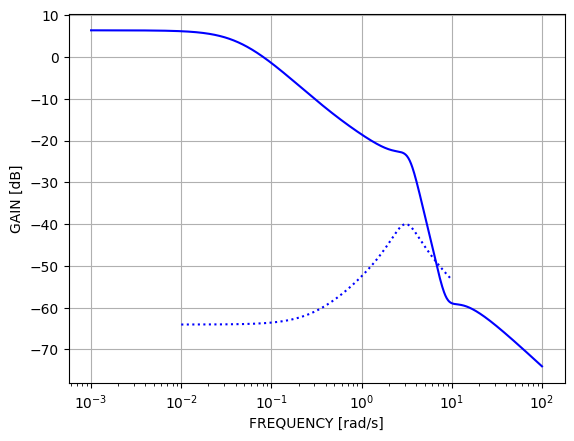

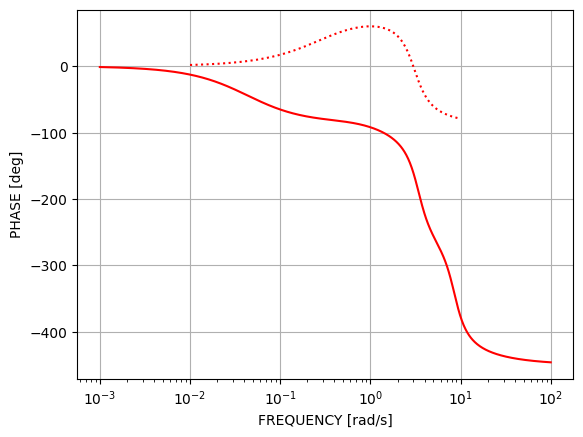

In [39]:
plt.figure(0)
plt.semilogx(w1, mag1,':b')    # Bode magnitude plot
plt.semilogx(w, mag,'b')    # Bode magnitude plot
plt.ylabel("GAIN [dB]")
plt.xlabel("FREQUENCY [rad/s]")
plt.grid()

plt.figure(1)
plt.semilogx(w1, phase1,':r')  # Bode phase plot
plt.semilogx(w, phase,'r')  # Bode phase plot
plt.xlabel("FREQUENCY [rad/s]")
plt.ylabel("PHASE [deg]")
plt.grid()

plt.show()


### Simulação Dinâmica
Ao se estimular q na simualçao é possível perceber o período de oscilação muito proximo ao calculado nas seções acima.

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 4.399997089796075e-19
       x: [ 8.088e-02 -1.407e-03 -6.455e-01 -1.728e-01 -2.441e-02
            8.712e-01]
     nit: 4
     jac: [-2.852e-03  4.073e-03  2.330e-05  1.172e-03  2.497e-05
            4.548e-03]
    nfev: 29
    njev: 4

Constraint eq 7.66204877322707e-11
Constraint eq 1.6018697917439232e-13
Constraint eq 6.74930333843804e-10
Constraint eq -3.119929136714618e-13
Constraint eq 3.1441057593363964e-12
Constraint eq 6.725326871179973e-13

Theta (deg):  4.633897817414228
Alpha (deg):  4.633897817414228
Alphadot (deg):  6.959880925607113e-11
Beta (deg):  -0.0806131969787281
Aileron (deg):  -11.61963287873462
Elevator (deg):  -3.1096100732487164
Rudder (deg):  -0.43936872551771283
Throtle:  0.8711872945485769
U_dot (m/s^2):  2.3301811680198626e-11
W_dot (m/s^2):  2.0565379372783355e-10
VT_dot_mag (m/s^2):  2.0696970141117213e-10
VT_dot_angle (deg):  83.53561332460804
END


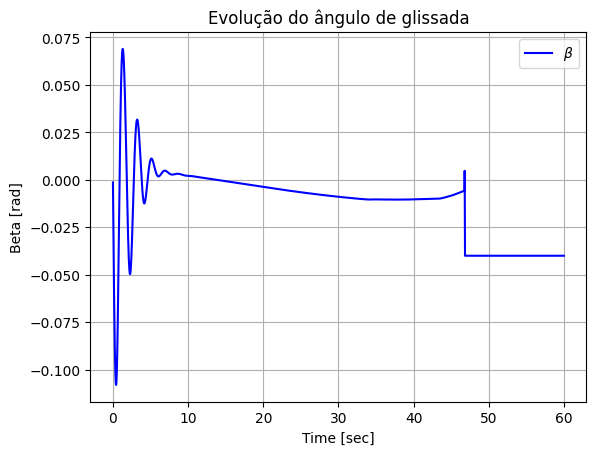

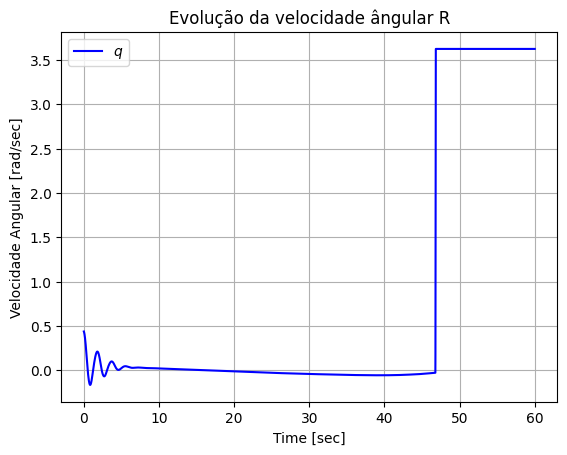

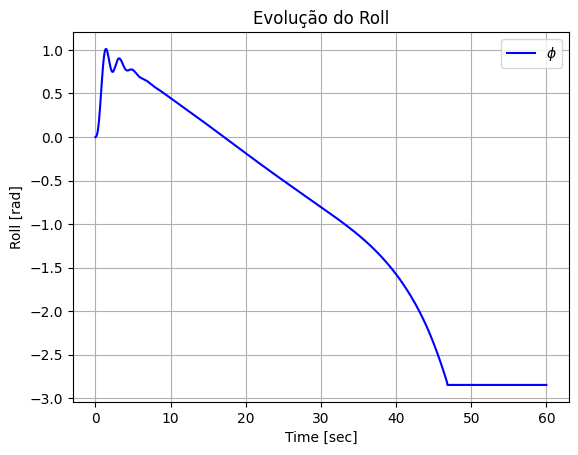

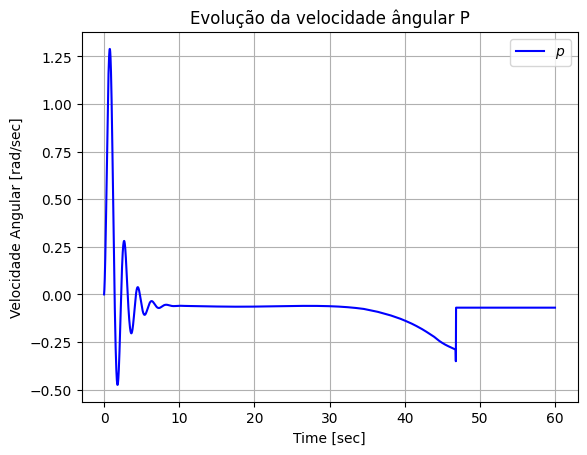

In [40]:
from pathlib             import Path
import matplotlib.pyplot as plt
import jsbsim
import time
import pandas               as pd
import numpy as np

# Data frame
data = []

# Simulação
realtime     = False
sim_period   = 60
num_steps = sim_period*100
frame_time   = 0
dt = sim_period/num_steps
frame_period = dt

# Configuração do JSBSim
aircraft_model='f104'
aircraft_path=(Path('.')/'..').resolve()
fdm = jsbsim.FGFDMExec(str(aircraft_path))
fdm.set_debug_level(0)
fdm.load_model(aircraft_model)
fdm.set_dt(dt)                                            # Define o passo da simulação (s)

# Condições Iniciais


op_cruise = trim.trim_wings_level_flight(
    fdm = fdm,
    ic_h_sl_ft = 5000,
    ic_mach = 0.5,
    fuel_content_lbs = 1000,
    debug_level=2,
    )


fdm['propulsion/tank[0]/contents-lbs'] = 1000
fdm['ic/h-sl-ft'] = 5000               # ft
fdm['ic/mach'] = 0.5
fdm['ic/r-rad_sec'] = np.deg2rad(25)
fdm.run_ic()

try:
           
    for i in range(num_steps):


        fdm['fcs/aileron-cmd-norm'] = op_cruise['fcs/aileron-cmd-norm']
        fdm['fcs/elevator-cmd-norm'] = op_cruise['fcs/elevator-cmd-norm']
        fdm['fcs/rudder-cmd-norm'] = op_cruise['fcs/rudder-cmd-norm']
        fdm['fcs/throttle-cmd-norm[0]'] = op_cruise['fcs/throttle-cmd-norm[0]']
            
        
        new_data = {
                    'sim-time-sec' : fdm.get_sim_time(),
                    'aero/beta-rad' : fdm['aero/beta-rad'],
                    'velocities/r-rad_sec' : fdm['velocities/r-rad_sec'],
                    'attitude/phi-rad' : fdm['attitude/phi-rad'],
                    'velocities/p-rad_sec' : fdm['velocities/p-rad_sec'], 
                    'position/h-agl-ft' : fdm['position/h-agl-ft'],
                    }
        
        data.append(new_data)       
        
        fdm.run()
        
        if fdm.get_sim_time() > 120:
            break                

        if realtime:
            
            if fdm.get_sim_time() > frame_time:
                frame_time += frame_period
                time.sleep(frame_period)

except ValueError as ve:
    print(f"Erro de valor encontrado: {ve}")

except KeyError as ke:
    print(f"Chave não encontrada no dicionário: {ke}")

except FileNotFoundError as fe:
    print(f"Arquivo não encontrado: {fe}")

except Exception as e:
    print(f"A simulação encontrou um erro: {type(e).__name__}: {e}")

finally:
    print('END')
                
    df = pd.DataFrame(data, columns=[
                    'sim-time-sec',
                    'aero/beta-rad',
                    'velocities/r-rad_sec',
                    'attitude/phi-rad',
                    'velocities/p-rad_sec', 
                    'position/h-agl-ft',
            ])
    
    plt.figure(0)
    plt.plot(df['sim-time-sec'], df['aero/beta-rad'], 'b', label=r'$\beta$')
    plt.legend()
    plt.xlabel('Time [sec]')
    plt.ylabel('Beta [rad]')
    plt.title('Evolução do ângulo de glissada')
    plt.grid()

    plt.figure(1)
    plt.plot(df['sim-time-sec'], df['velocities/r-rad_sec'],'b', label=r'$q$')
    plt.legend()
    plt.xlabel('Time [sec]')
    plt.ylabel('Velocidade Angular [rad/sec]')
    plt.title('Evolução da velocidade ângular R')
    plt.grid()

    plt.figure(2)
    plt.plot(df['sim-time-sec'], df['attitude/phi-rad'], 'b', label=r'$\phi$')
    plt.legend()
    plt.xlabel('Time [sec]')
    plt.ylabel('Roll [rad]')
    plt.title('Evolução do Roll')
    plt.grid()

    plt.figure(3)
    plt.plot(df['sim-time-sec'], df['velocities/p-rad_sec'],'b', label=r'$p$')
    plt.legend()
    plt.xlabel('Time [sec]')
    plt.ylabel('Velocidade Angular [rad/sec]')
    plt.title('Evolução da velocidade ângular P')
    plt.grid()

    # Mostrar a imagem
    plt.show()    
